In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import time

In [2]:
url_boundary = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/coordinates_with_region.csv"
url_centroids = "https://raw.githubusercontent.com/naufalaschafitz/TugasAkhir/refs/heads/main/Centroids.csv"
df_boundary = pd.read_csv(url_boundary)
df_centroids = pd.read_csv(url_centroids)

outer_points = df_boundary[df_boundary["Region"] == "outer"][["X", "Y"]].values
inner_1_points = df_boundary[df_boundary["Region"] == "inner_1"][["X", "Y"]].values
inner_2_points = df_boundary[df_boundary["Region"] == "inner_2"][["X", "Y"]].values
inner_3_points = df_boundary[df_boundary["Region"] == "inner_3"][["X", "Y"]].values

outer_points_closed = np.vstack([outer_points, outer_points[0]])
inner_1_points_closed = np.vstack([inner_1_points, inner_1_points[0]])
inner_2_points_closed = np.vstack([inner_2_points, inner_2_points[0]])
inner_3_points_closed = np.vstack([inner_3_points, inner_3_points[0]])

centroids = df_centroids[["X", "Y"]].values
main_labels = df_centroids["MainCluster"].values
sub_labels = df_centroids["SubCluster"].values

# Peta warna
unique_clusters = sorted(set(main_labels))
cmap = plt.get_cmap("tab10", len(unique_clusters))
cluster_color_map = {c: cmap(i) for i, c in enumerate(unique_clusters)}

# Extract centroid coordinates and append depot
all_centroids = df_centroids[["X", "Y"]].values
coords_with_depot = np.vstack([[0, 0], all_centroids])

distance_matrix = cdist(coords_with_depot, coords_with_depot)

def fitness(tour, distance_matrix):
    return sum(distance_matrix[tour[i], tour[i+1]] for i in range(len(tour)-1)) + distance_matrix[tour[-1], tour[0]]

def generate_greedy_initial_route(distance_matrix):
    n = len(distance_matrix)
    unvisited = set(range(1, n))  # node 0 = depot, jadi mulai dari 1
    route = [0]  # mulai dari depot

    current = 0
    while unvisited:
        next_node = min(unvisited, key=lambda x: distance_matrix[current][x])
        route.append(next_node)
        unvisited.remove(next_node)
        current = next_node

    return route

def two_opt(route, distance_matrix, max_iter=1000):
    best = route
    improved = True
    while improved and max_iter > 0:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route) - 1):
                if j - i == 1:
                    continue  # Skip adjacent nodes
                new_route = best[:i] + best[i:j][::-1] + best[j:]
                if fitness(new_route, distance_matrix) < fitness(best, distance_matrix):
                    best = new_route
                    improved = True
        max_iter -= 1
    return best

def get_neighbor(route):
    new_route = route[:]
    i, j = sorted(np.random.choice(range(1, len(route)), size=2, replace=False)) 
    move_type = np.random.choice(["reverse", "swap", "insert"])

    if move_type == "reverse":
        new_route[i:j+1] = reversed(new_route[i:j+1])

    elif move_type == "swap":
        new_route[i], new_route[j] = new_route[j], new_route[i]

    elif move_type == "insert":
        node = new_route.pop(i)
        new_route.insert(j, node)

    return new_route


def simulated_annealing(
    distance_matrix,
    initial_route,
    initial_temp=100,
    cooling_rate=0.99,
    stopping_temp=1e-4,
    max_iter=2000,
    interval_log=50,
    n_iter_2opt=10,
    local_max_iter=30
):
    current_route = initial_route[:]
    current_cost = fitness(current_route, distance_matrix)
    best_route = current_route[:]
    best_cost = current_cost
    temperature = initial_temp
    cost_log = []

    iteration = 0
    while temperature > stopping_temp and iteration < max_iter:
        # Tetangga: reverse segment (2-opt-like ringan)
        neighbor_route = get_neighbor(current_route)

        # Setiap n iterasi → refine dengan 2-Opt
        if iteration % n_iter_2opt == 0:
            neighbor_route = two_opt(neighbor_route, distance_matrix, max_iter=local_max_iter)

        neighbor_cost = fitness(neighbor_route, distance_matrix)

        # Acceptance
        if neighbor_cost < current_cost or np.random.rand() < np.exp((current_cost - neighbor_cost) / temperature):
            current_route = neighbor_route
            current_cost = neighbor_cost
            if current_cost < best_cost:
                best_route = current_route[:]
                best_cost = current_cost

        cost_log.append(current_cost)
    

        if iteration % interval_log == 0:
            print(f"Iterasi {iteration:4d} | Cost: {current_cost:.2f} | Best: {best_cost:.2f} | Suhu: {temperature:.2f}")

        # Cooling
        temperature *= cooling_rate
        iteration += 1

    print(f"Final Iterasi {iteration} | Best Cost: {best_cost:.2f}")
    return best_route, best_cost, cost_log


In [3]:
num_runs = 10
all_best_costs = []
all_best_routes = []
all_cost_logs = []
all_durations = []

for run in range(num_runs):
    initial_route = generate_greedy_initial_route(distance_matrix)
    start_time = time.time()
    best_route, best_cost, cost_log = simulated_annealing(distance_matrix, initial_route)
    duration = time.time() - start_time
    all_best_costs.append(best_cost)
    all_best_routes.append(best_route)
    all_cost_logs.append(cost_log)
    all_durations.append(duration)

max_len = max(len(log) for log in all_cost_logs)
cost_df = pd.DataFrame({f"Run {i+1}": log + [None] * (max_len - len(log)) for i, log in enumerate(all_cost_logs)})

# Cari index dari run dengan best cost terkecil
best_run_index = np.argmin(all_best_costs)
best_run_log = all_cost_logs[best_run_index]

# Tabel hasil best cost dan durasi
results_df = pd.DataFrame({
    "Run": [f"Run {i+1}" for i in range(num_runs)],
    "Best Cost": [f"{c:.2f}" for c in all_best_costs],
    "Durasi (detik)": [f"{t:.2f}" for t in all_durations]
})

from IPython.display import display 
display(results_df)

Iterasi    0 | Cost: 1926.06 | Best: 1926.06 | Suhu: 100.00
Iterasi   50 | Cost: 1754.45 | Best: 1748.08 | Suhu: 60.50
Iterasi  100 | Cost: 1799.22 | Best: 1748.08 | Suhu: 36.60
Iterasi  150 | Cost: 1792.56 | Best: 1748.08 | Suhu: 22.15
Iterasi  200 | Cost: 1787.95 | Best: 1748.08 | Suhu: 13.40
Iterasi  250 | Cost: 1778.27 | Best: 1748.08 | Suhu: 8.11
Iterasi  300 | Cost: 1765.70 | Best: 1748.08 | Suhu: 4.90
Iterasi  350 | Cost: 1765.70 | Best: 1748.08 | Suhu: 2.97
Iterasi  400 | Cost: 1747.04 | Best: 1747.04 | Suhu: 1.80
Iterasi  450 | Cost: 1747.04 | Best: 1747.04 | Suhu: 1.09
Iterasi  500 | Cost: 1737.03 | Best: 1737.03 | Suhu: 0.66
Iterasi  550 | Cost: 1734.68 | Best: 1734.68 | Suhu: 0.40
Iterasi  600 | Cost: 1734.68 | Best: 1734.68 | Suhu: 0.24
Iterasi  650 | Cost: 1734.93 | Best: 1734.68 | Suhu: 0.15
Iterasi  700 | Cost: 1720.41 | Best: 1720.41 | Suhu: 0.09
Iterasi  750 | Cost: 1720.12 | Best: 1720.12 | Suhu: 0.05
Iterasi  800 | Cost: 1720.12 | Best: 1720.12 | Suhu: 0.03
Iterasi 

,Run,Best Cost,Durasi (detik)
0,Run 1,1717.69,161.03
1,Run 2,1730.33,155.78
2,Run 3,1742.50,161.61
3,Run 4,1747.27,169.62
4,Run 5,1706.49,171.90
5,Run 6,1788.98,176.02
6,Run 7,1739.24,191.66
7,Run 8,1721.05,175.00
8,Run 9,1718.47,193.71
9,Run 10,1764.96,178.75


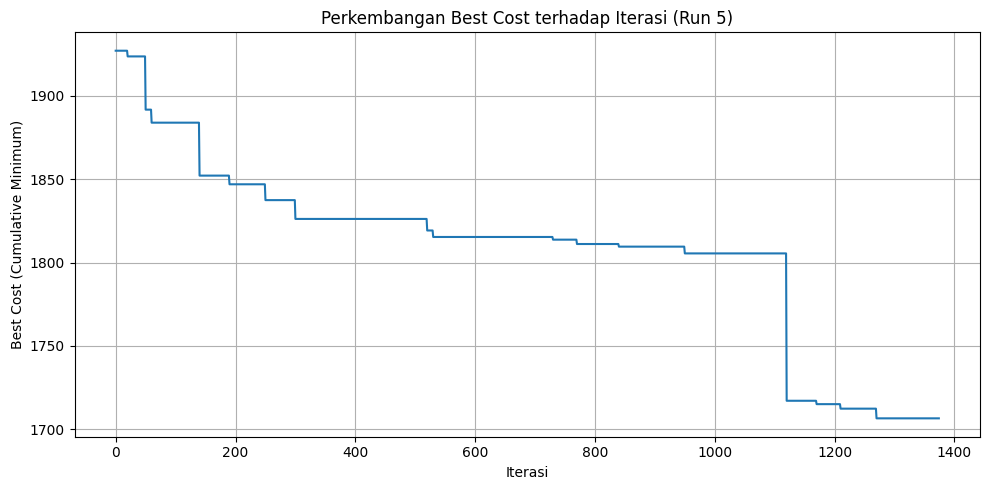

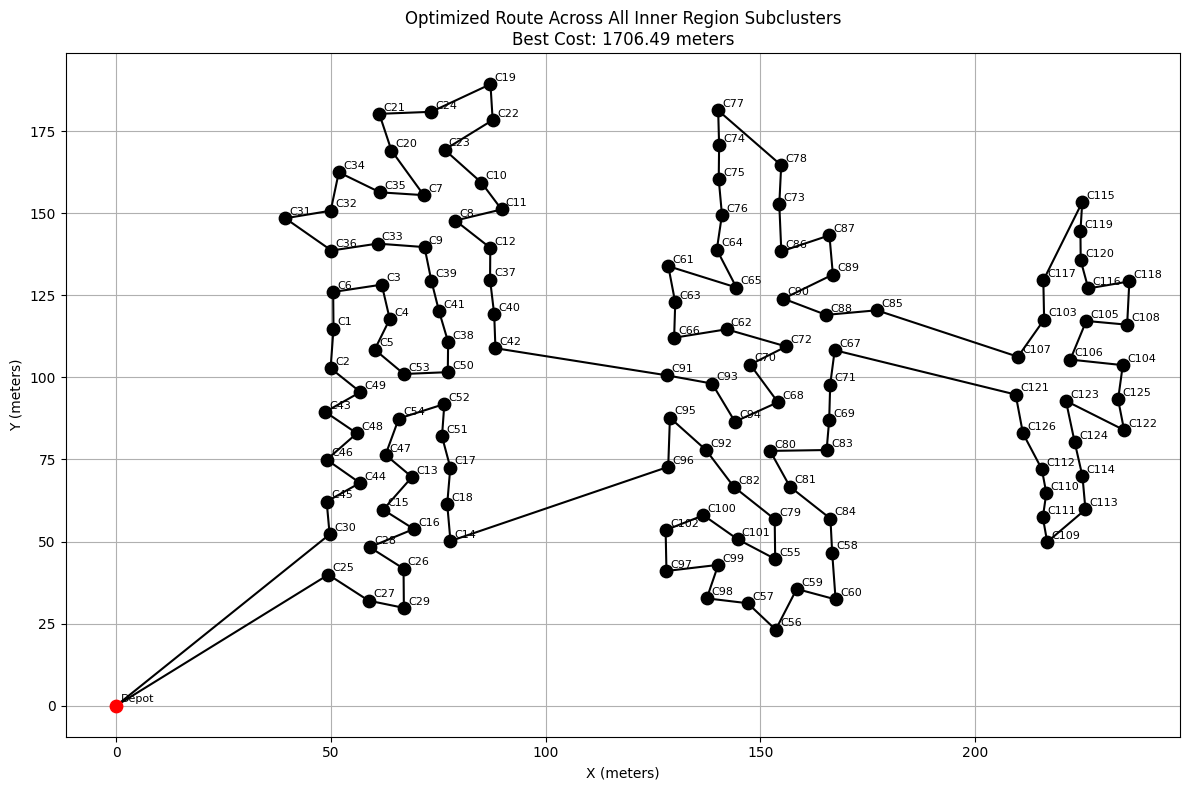

In [4]:
# Buat array untuk best cost pada setiap iterasi (cumulative minimum)
best_cost_progress = np.minimum.accumulate(best_run_log)

# Plot grafik konvergensi best cost terhadap iterasi
plt.figure(figsize=(10, 5))
plt.plot(best_cost_progress)
plt.title(f"Perkembangan Best Cost terhadap Iterasi (Run {best_run_index + 1})")
plt.xlabel("Iterasi")
plt.ylabel("Best Cost (Cumulative Minimum)")
plt.grid(True)
plt.tight_layout()
plt.show()

best_index = np.argmin(all_best_costs)
best_route = all_best_routes[best_index]
best_cost = all_best_costs[best_index]

# Visualisasi dengan style sesuai permintaan user
plt.figure(figsize=(12, 8))

# Gambar garis antar titik sesuai urutan rute
for i in range(len(best_route) - 1):
    start = coords_with_depot[best_route[i]]
    end = coords_with_depot[best_route[i + 1]]
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Hubungkan titik terakhir ke titik awal (depot)
start = coords_with_depot[best_route[-1]]
end = coords_with_depot[best_route[0]]
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', linewidth=1.5)

# Plot titik-titik dan beri label
for i, idx in enumerate(best_route):
    point = coords_with_depot[idx]
    label = "Depot" if idx == 0 else f"C{idx}"
    plt.scatter(point[0], point[1], c='red' if idx == 0 else 'black', s=80, zorder=5)
    plt.annotate(label, (point[0] + 1, point[1] + 1), fontsize=8)

# Judul dan axis
plt.title(f"Optimized Route Across All Inner Region Subclusters\nBest Cost: {best_cost:.2f} meters")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.grid(True)
plt.tight_layout()
plt.show()



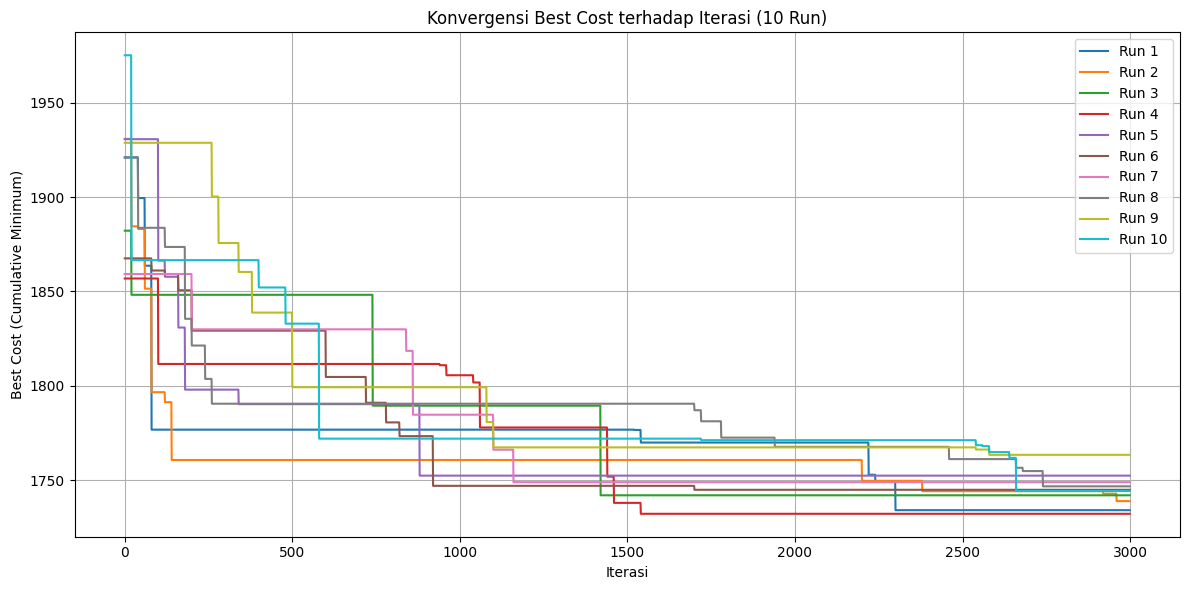

In [5]:
# Buat grafik konvergensi best cost untuk semua 10 run (cumulative minimum)
plt.figure(figsize=(12, 6))

for i, log in enumerate(all_cost_logs):
    best_progress = np.minimum.accumulate(log)
    plt.plot(best_progress, label=f"Run {i+1}")

plt.xlabel("Iterasi")
plt.ylabel("Best Cost (Cumulative Minimum)")
plt.title("Konvergensi Best Cost terhadap Iterasi (10 Run)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()